In [2]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/.kaggle'

In [3]:
# !mkdir '/content/drive/MyDrive/simpsons/models/simple_cnn'

In [4]:
# !chmod 600 /content/drive/MyDrive/.kaggle/kaggle.json

In [5]:
# !kaggle competitions download -c journey-springfield -p '/content/drive/MyDrive/simpsons/dataset/'
# !kaggle datasets download -d "username/dataset-name" -p "/путь/для/сохранения"

In [6]:
# !kaggle datasets download -d "dariju/simpsons_1" -p "/content/drive/MyDrive/simpsons/models/"

In [7]:
# !rm -rf /content/drive/MyDrive/simpsons/models/kaggle


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [8]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# %config Completer.use_jedi = False

In [10]:
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [11]:
!nvidia-smi
print(torch.cuda.is_available())

Fri Apr 25 07:48:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [13]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [14]:
!python --version

Python 3.11.11


In [15]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow', 'scikit-learn']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.5
seaborn version: 0.12.2
Pillow version: 11.1.0
scikit-learn version: 1.2.2


In [16]:
# !pip install torch torchvision tqdm matplotlib seaborn Pillow scikit-learn --upgrade

#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [17]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [18]:
torch.cuda.is_available()

True

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [19]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [20]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [21]:
import os

if "COLAB_RELEASE_TAG" in os.environ and not "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    print("This is Google Colab")
    START_PATH = '/content/drive/MyDrive/simpsons'
    TRAIN_DIR = Path(START_PATH + '/dataset/train/')
    TEST_DIR = Path(START_PATH + '/dataset/testset')
    MODEL_PATH = START_PATH + '/models/'
elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    print("This is Kaggle")
    START_PATH = '/kaggle/input'
    TRAIN_DIR = Path(START_PATH + '/journey-springfield/train')
    TEST_DIR = Path(START_PATH + '/journey-springfield/testset')
    MODEL_PATH = START_PATH + '/simpson_simple_cnn/pytorch/simpson_mdl/1'
    OUTPUT_PATH = '/kaggle/working/'

This is Kaggle


In [22]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [23]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [24]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [25]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

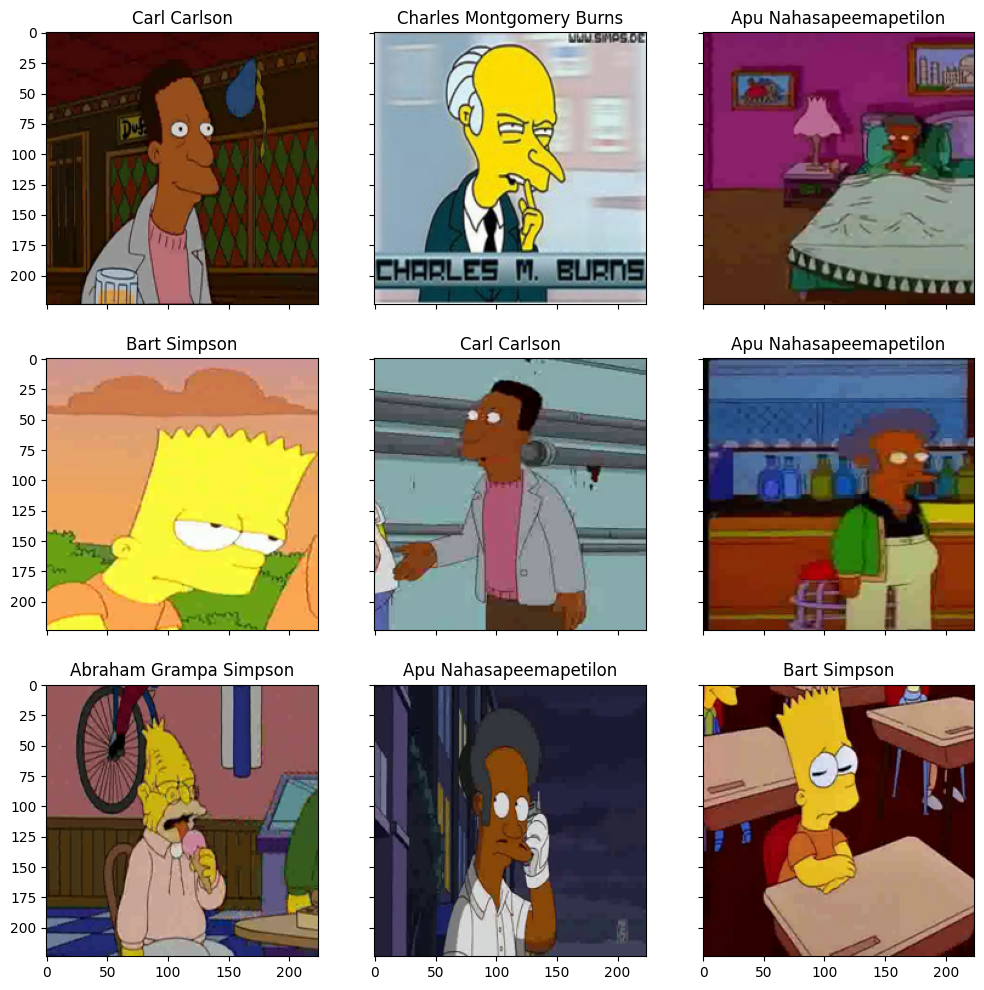

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [27]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

#### Функция обучения:

In [28]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0


    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [29]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [30]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val_loss = float('inf')
    patience = 3
    no_improve = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            #-------------my_code---------------#
            # Условие ранней остановки
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    tqdm.write(f"Early stopping at epoch {epoch+1}")
                    break
            #-------------my_code---------------#
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [31]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        model.eval()
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [32]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(simple_cnn)

we will classify :42


Запустим обучение сети.

In [33]:
if val_dataset is None or train_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

In [34]:
import json

n_classes = len(np.unique(train_val_labels))

modl_path = Path(MODEL_PATH + '/simple_cnn.pth')
if modl_path.exists():
    simple_cnn = SimpleCnn(n_classes)
    simple_cnn.load_state_dict(torch.load(
        MODEL_PATH + '/simple_cnn.pth',
        weights_only= True,
        map_location = torch.device(DEVICE)))
    simple_cnn.to(DEVICE)
    with open(MODEL_PATH + '/history.json', 'r') as json_file:
        history = json.load(json_file)
else:
    history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)
    torch.save(simple_cnn.state_dict(), 'simple_cnn.pth', )
    with open('history.json', 'w') as json_file:
        json.dump([[v1, v2, v3, v4.cpu().tolist()] for v1, v2, v3, v4 in history], json_file)

Построим кривые обучения

In [35]:
loss, acc, val_loss, val_acc = zip(*history)

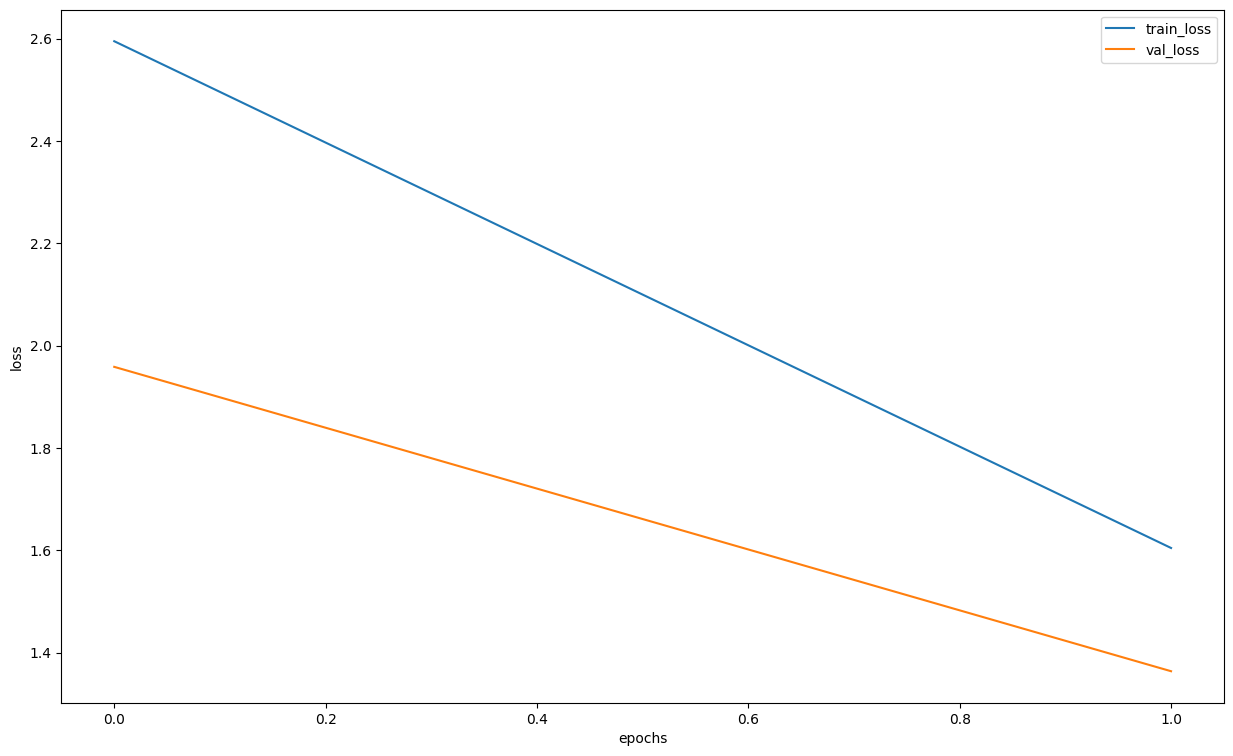

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [37]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [38]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [39]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [40]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [41]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [42]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.5


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

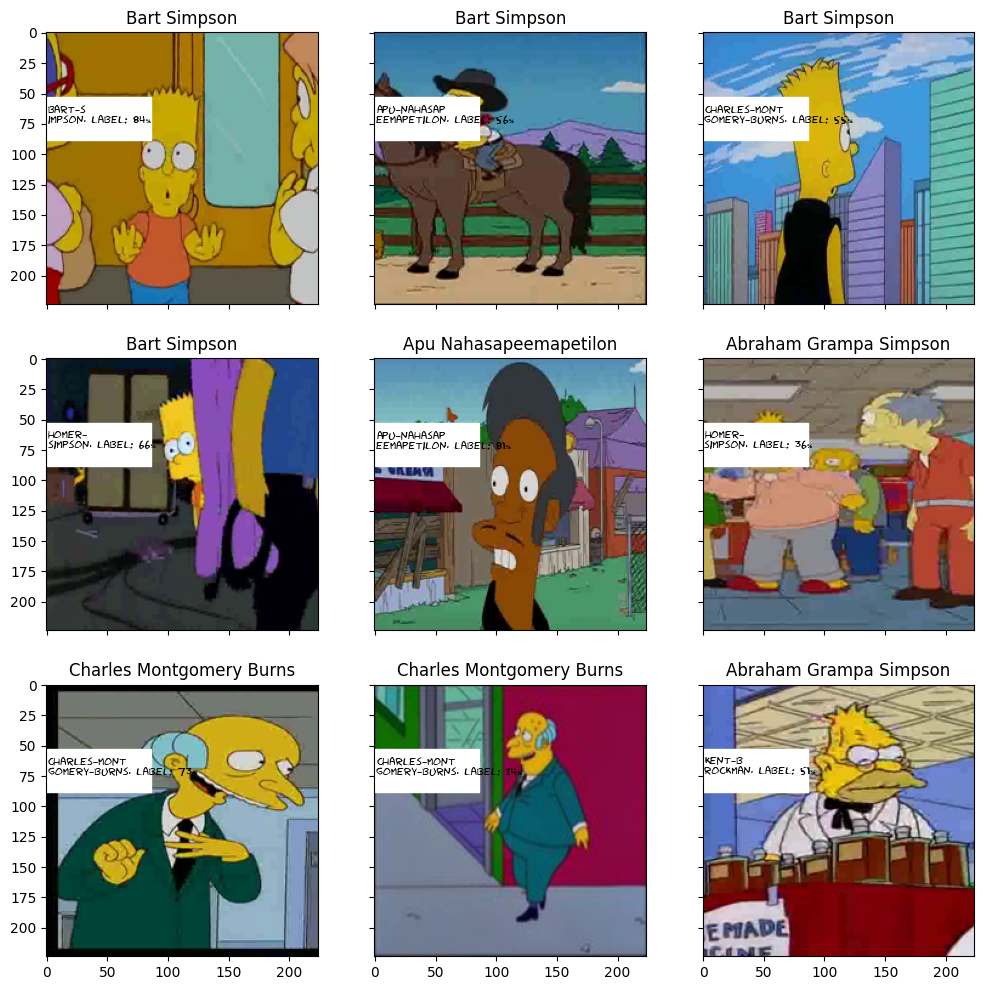

In [43]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{}, label: {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [44]:
# label_var = None
# char_name = None

# simple_cnn.eval()
# prob_dict = dict()
# encoder = val_dataset.label_encoder
# for image, label in tqdm(val_dataset):
#   prob_values = predict_one_sample(simple_cnn, image.unsqueeze(0))
#   char_name = encoder.inverse_transform([label])[0]
#   if label != label_var:
#       label_var = label
#       prob_dict[char_name] = []
#   prob_dict[char_name].append(prob_values[0][label].item())

In [45]:
# mean_probs = {label: 100 * np.mean(prob_arr) for label, prob_arr in prob_dict.items()}
# mean_probs = dict(sorted(mean_probs.items(), key=lambda item: item[1]))

# plt.figure(figsize=(90, 90))

# plt.barh(list(mean_probs.keys()), list(mean_probs.values()))
# # plt.xlabel('Class Names', fontsize=50)
# # plt.ylabel('Mean Probability', fontsize=50)
# plt.yticks(fontsize=60, fontname='Arial')
# plt.title('Mean Probabilities by Class')
# plt.xticks(fontsize=60, fontname='Arial')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [47]:
# import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
# # my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
# my_submit.head()

In [48]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [49]:
# my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


Last score: 0.65.

In [50]:
from collections import Counter

try:
    import imagehash
except ImportError:
    !pip install imagehash
    import imagehash

class PreprocessData():
    def __init__(self):
        self.classes = 0

    def augmentate_and_save(self, files):
        labels = [path.parent.name for path in files]
        self.classes = Counter(labels)
        transform = None

        pointer = 0
        num_aug = 0
        aug_data = Path('/content/drive/MyDrive/simpsons/aug_data')
        for label, count in self.classes.items():
            # if count < 100:
            #   transform = self._medium_augmentation()
            # elif count < 10:
            if count < 10:
              transform = self._strong_augmentation()
              class_dir = base_path / label
              class_dir.mkdir(parents=True, exist_ok=True)
              for idx in range(pointer, pointer + count):
                save_path = class_dir / idx
                trs_img = transform(files[idx])
                augmented_img = transforms.ToPILImage()(trs_img)  # Конвертируем тензор → PIL
                augmented_img.save(save_path)  # Сохраняется в RGB
            pointer += count

    def _medium_augmentation():
        transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(p=0.4),
                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                  # transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                  transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        return transform

    def _strong_augmentation():
        transform = torch.transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(p=1),
                  transforms.RandomRotation(45),
                  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                  transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                  transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
                  transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                  transforms.GaussianBlur(kernel_size=3),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        return transform


    def clear_duplicate(self, files):

        labels = [path.parent.name for path in files]
        self.classes = Counter(labels)

        # img_hashes = []
        # for p in files:
        #     img_hashes.append(imagehash.phash(Image.open(p), hash_size=8))

        pointer = 0
        new_files = []
        duplicate = dict()
        for name_class, count_img in tqdm(self.classes.items()):
            hash_arr = []
            duplicate[name_class] = []
            for idx in range(pointer, pointer + count_img):
                hash = imagehash.phash(Image.open(files[idx]), hash_size=8)
                if not any(hash - compared < 10 for compared in hash_arr):
                    new_files.append(files[idx])
                    hash_arr.append(hash)
                else:
                  duplicate[name_class].append(files[idx])
            pointer += count_img
        return new_files, duplicate

In [51]:
# dat = PreprocessData()

In [52]:
# new_files, duplicate = dat.clear_duplicate(files=train_val_files)

# cleared_train_labels = [path.parent.name for path in new_files]
# train_files_1, val_files_1 = train_test_split(new_files, test_size=0.25, stratify=cleared_train_labels)

# new_train = SimpsonsDataset(files=train_files_1, mode='train')
# new_val = SimpsonsDataset(files=val_files_1, mode='val')

In [53]:
def compare_two_distribution(dict1, dict2):
    plt.figure(figsize=(90, 90))

    plt.barh(width = list(dict1.values()), y=list(dict1.keys()), alpha = 0.7, color='red', edgecolor='black')
    plt.yticks(fontsize=20)  # Размер шрифта для меток по оси Y (названия категорий)
    # plt.xticks(fontsize=12)
    plt.barh(width = list(dict2.values()), y=list(dict2.keys()), alpha = 0.4, color='blue', edgecolor='black')
    plt.show()

In [54]:
# old_distribution = Counter(train_dataset.labels)
# new_distribution = Counter(new_train.labels)
# compare_two_distribution(old_distribution, new_distribution)

# plt.figure(figsize=(50, 50))
# # fig, ax = plt.subplots(2, 1, figsize= (70, 70))
# plt.barh(width = list(old_distribution.values()), y=list(old_distribution.keys()), alpha = 0.7, color='blue', edgecolor='black',)
# plt.barh(width = list(new_distribution.values()), y=list(new_distribution.keys()), alpha = 0.4, color='red', edgecolor='black',)
# plt.show()

In [55]:
# model_1 = SimpleCnn(n_classes).to(DEVICE)
# history_1 = train(new_train, new_val, model=model_1, epochs=2, batch_size=64)

In [56]:
# loss, acc, val_loss, val_acc = zip(*history_1)
# plt.figure(figsize=(15, 9))
# plt.plot(loss, label="train_loss")
# plt.plot(val_loss, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

In [57]:
def calc_score(cnn, val_dataset):
    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(cnn, imgs)

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]

    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-оценка:", f1)

In [58]:
# calc_score(model_1, new_val)

In [59]:
def mean_distribution_preds(cnn, val_dataset):
    label_var = None
    char_name = None

    cnn.eval()
    prob_dict = dict()
    encoder = val_dataset.label_encoder
    for image, label in tqdm(val_dataset):
        prob_values = predict_one_sample(cnn, image.unsqueeze(0))
        char_name = encoder.inverse_transform([label])[0]
        if label != label_var:
          label_var = label
          prob_dict[char_name] = []
        prob_dict[char_name].append(prob_values[0][label].item())

    mean_probs = {label: 100 * np.mean(prob_arr) for label, prob_arr in prob_dict.items()}
    mean_probs = dict(sorted(mean_probs.items(), key=lambda item: item[1]))
    return mean_probs

In [60]:
# mean_probs_1 = mean_distribution_preds(model_1, new_val)

In [61]:
# compare_two_distribution(mean_probs_1, mean_probs)

In [62]:
# from sklearn.ensemble import IsolationForest
# import numpy as np

# def detect_outliers(dataset, contamination=0.01):
#     arr = []
#     p = []
#     val = 0
#     for images, _ in dataset:
#       [arr.append(i.mean(dim=0).numpy()) for i in images]
#       if len(arr) > 33 + val:
#         clf = IsolationForest(
#             contamination=contamination,
#             n_estimators=100,
#             max_samples=33,  # Размер подвыборки для каждого дерева
#             random_state=42
#         )
#         p.append(clf.fit_predict(arr))
#         val += 33
#     return np.where(preds == -1)[0]

In [63]:
from collections import Counter

try:
    import imagehash
except ImportError:
    !pip install imagehash
    import imagehash


class MyDataset(SimpsonsDataset):
  def __init__(self, files, mode, augmentation_count = 100):
    self.files = sorted(files)
    if mode == "train":
        self.files, duplicate = self.__clear_duplicate(self.files)
        self.files = self.augmentate_and_save(self.files, augmentation_count)
    super().__init__(self.files, mode)
    self.classes = Counter(self.labels)

  def augmentate_save_with_equal_classes(self, files, aug_per_class = 100):
        labels = [path.parent.name for path in files]
        self.classes = Counter(labels)
        transform = None

        pointer = 0
        num_aug = 0
        new_files = np.empty(shape=0)
        for label, count in tqdm(self.classes.items()):
            if count > aug_per_class:
                index = [pointer + r for r in np.random.choice(count, size=aug_per_class, replace=False)]
                new_files = np.concatenate([new_files, np.take(self.files, index)])
            elif count <= aug_per_class:
              p = Path(MODEL_PATH) / 'aug_pictures' / label
              if p.exists():
                  new_files = np.concatenate([sorted(list(p.rglob('*.jpg'))), new_files])
              else:
                  transform = self._strong_augmentation()
                  out_dir = Path(OUTPUT_PATH) / 'pictures' / label
                  out_dir.mkdir(parents=True, exist_ok=True)
                  path_array = []
                  needed_aug = aug_per_class - count
                  created = 0
                  while created < needed_aug:
                      for idx in range(pointer, pointer + count):
                        if created > needed_aug: 
                            break
                        save_path = out_dir / f'{created + idx}.jpg'
                        img = self._prepare_sample(self.load_sample(files[idx]))
                        img = transform(np.array(img / 255, dtype='float32'))
                        transforms.ToPILImage()(img).save(save_path) # Конвертируем тензор → PIL  # Сохраняется в RGB
                        path_array.append(save_path)
                        created += 1
                  new_files = np.concatenate([new_files, self.files[pointer : pointer + count], path_array])
            pointer += count
        self.classes = Counter(labels)
        return new_files


  def augmentate_and_save(self, files, aug_per_class = 100):
        labels = [path.parent.name for path in files]
        self.classes = Counter(labels)
        transform = None

        pointer = 0
        num_aug = 0
        new_files = np.empty(shape=0)
        for label, count in tqdm(self.classes.items()):
            if count > aug_per_class:
                index = [pointer + r for r in np.random.choice(count, size=aug_per_class, replace=False)]
                new_files = np.concatenate([new_files, np.take(self.files, index)])
            elif count <= aug_per_class:
              p = Path(MODEL_PATH) / 'aug_pictures' / label
              if p.exists():
                  new_files = np.concatenate([sorted(list(p.rglob('*.jpg'))), new_files])
              else:
                  transform = self._strong_augmentation()
                  out_dir = Path(OUTPUT_PATH) / 'pictures' / label
                  out_dir.mkdir(parents=True, exist_ok=True)
                  path_array = []
                  needed_aug = aug_per_class - count
                  created = 0
                  while created < needed_aug:
                      for idx in range(pointer, pointer + count):
                        if created > needed_aug: 
                            break
                        save_path = out_dir / f'{created + idx}.jpg'
                        img = self._prepare_sample(self.load_sample(files[idx]))
                        img = transform(np.array(img / 255, dtype='float32'))
                        transforms.ToPILImage()(img).save(save_path) # Конвертируем тензор → PIL  # Сохраняется в RGB
                        path_array.append(save_path)
                        created += 1
                  new_files = np.concatenate([new_files, self.files[pointer : pointer + count], path_array])
            pointer += count
        self.classes = Counter(labels)
        return new_files

  def _medium_augmentation(self):
      transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.4),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                # transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
              ])
      return transform

  def _strong_augmentation(self):
      transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                transforms.GaussianBlur(kernel_size=3),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
              ])
      return transform

  def __getitem__(self, index):
    # для преобразования изображений в тензоры PyTorch и нормализации входа

    # self.classes = Counter(self.labels)
    # pointer = 0
    # num_aug = 0
    # for label, count in self.classes.items():
    #   if count < 100:
    #     transform = self._medium_augmentation()

    #   elif count < 10:
    #     transform = self._strong_augmentation()
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    # x = transform(x)
    if self.mode == 'test':
        return x
    else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

  def __clear_duplicate(self, files, boundary_duplicate = 10):
        labels = [path.parent.name for path in files]
        self.classes = Counter(labels)

        # img_hashes = []
        # for p in files:
        #     img_hashes.append(imagehash.phash(Image.open(p), hash_size=8))

        pointer = 0
        new_files = []
        duplicate = dict()
        for name_class, count_img in tqdm(self.classes.items()):
            hash_arr = []
            duplicate[name_class] = []
            for idx in range(pointer, pointer + count_img):
                _hash = imagehash.phash(Image.open(files[idx]), hash_size=8)
                if not any(_hash - compared < boundary_duplicate for compared in hash_arr):
                    new_files.append(files[idx])
                    hash_arr.append(_hash)
                else:
                  duplicate[name_class].append(files[idx])
            pointer += count_img
        return new_files, duplicate

In [64]:
# !rm -rf /kaggle/working/pictures

In [65]:
# mydat = MyDataset(train_files, mode = 'train')
# new_distribution = Counter(mydat.labels)
# old_distribution = Counter(train_dataset.labels)
# compare_two_distribution(old_distribution, new_distribution)

In [66]:
def test_neural_1():
    figure, ax = plt.subplots(1, 2, figsize=(40, 40))
    new_val = MyDataset(files=val_files, mode='val')

    count_array = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    result_array = []
    for aug_count in count_array:
        new_train = MyDataset(files=train_files, mode='train', augmentation_count=aug_count)
        model_1 = SimpleCnn(n_classes).to(DEVICE)
        history_1 = train(new_train, new_val, model=model_1, epochs=2, batch_size=64)
        calc_score(model_1, val_dataset)
        loss, acc, val_loss, val_acc = zip(*history_1)
        result_array.append((loss, val_loss, aug_count))

    for train_loss, val_loss, aug_count in result_array:
        ax[0].plot(train_loss, label="train_loss" + f"-{aug_count}")
        ax[1].plot(val_loss, label="vall_loss" + f"-{aug_count}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    
    # plt.figure(figsize=(15, 9))
    # plt.plot(loss, label="train_loss")
    # plt.plot(val_loss, label="val_loss")
    plt.show()

In [67]:
# test_neural()

In [68]:
def test_neural_2():
    aug_count = 400
    figure, ax = plt.subplots(1, 2, figsize=(50, 50))
    new_val = MyDataset(files=val_files, mode='val')
    new_train = MyDataset(files=train_files, mode='train', augmentation_count=aug_count)

    epoch_array = [5, 10, 13, 17]
    result_array = []
    for _epochs in epoch_array:
        model_1 = SimpleCnn(n_classes).to(DEVICE)
        history_1 = train(new_train, new_val, model=model_1, epochs=_epochs, batch_size=64)
        calc_score(model_1, val_dataset)
        loss, acc, val_loss, val_acc = zip(*history_1)
        result_array.append((loss, val_loss, _epochs))

    for loss, val_loss, _epoch in result_array:
        ax[0].plot(loss, label="train_loss" + f"-{_epoch}")
        ax[1].plot(val_loss, label="vall_loss" + f"-{_epoch}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [69]:
# !rm -rf /kaggle/working/pictures
# test_neural_2()

In [70]:
def get_distribution(dataset):
    allOf = len(dataset.labels)
    distribution = dict()
    for label, count in Counter(dataset.labels).items():
        rounded_mantissa = count / allOf
    
        # scientific_str = "{:.00e}".format(count / allOf)
        # # Разделяем мантиссу и экспоненту (например, ['1', '-04'])
        # mantissa, exponent = scientific_str.split('e')
        # # Округляем мантиссу до нужного числа знаков
        # rounded_mantissa = round(float(mantissa), 3)
        # # Если после округления получилось 10.0, корректируем
        # # if rounded_mantissa == 10.0:
        # #     rounded_mantissa = 1.0
        # #     exponent = int(exponent) + 1
            
        distribution[label] = rounded_mantissa #* (10 ** int(exponent))
    return distribution


In [71]:
class_weight = torch.Tensor(list(get_distribution(train_dataset).values())).to(DEVICE)

In [72]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val_loss = float('inf')
    patience = 3
    no_improve = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.01, amsgrad= False)
        criterion = nn.CrossEntropyLoss(weight=class_weight)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            #-------------my_code---------------#
            # Условие ранней остановки
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    tqdm.write(f"Early stopping at epoch {epoch+1}")
                    break
            #-------------my_code---------------#
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [83]:
def test_neural_3(test_dataset):
    epoch = 7
    result_array = []
    model_3 = SimpleCnn(n_classes).to(DEVICE)
    history_3 = train(train_dataset, val_dataset, model=model_3, epochs=epoch, batch_size=16)
    calc_score(model_3, val_dataset)
    loss, acc, val_loss, val_acc = zip(*history_3)
    result_array.append((loss, val_loss))

    figure, ax = plt.subplots(1, 2, figsize=(50, 50))
    for loss, val_loss in result_array:
        ax[0].plot(loss, label="train_loss")
        ax[1].plot(val_loss, label="vall_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        model.eval()
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            # outputs = model(inputs.unsqueeze(0)).cpu()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 1.8359570531966511


epoch:  14%|█▍        | 1/7 [04:25<26:34, 265.79s/it]


Epoch 001 train_loss: 1.8360     val_loss 1.5997 train_acc 0.3763 val_acc 0.5533
loss 0.9454905394422255


epoch:  29%|██▊       | 2/7 [06:35<15:29, 185.85s/it]


Epoch 002 train_loss: 0.9455     val_loss 1.0957 train_acc 0.6515 val_acc 0.6972
loss 0.5935820922055239


epoch:  43%|████▎     | 3/7 [08:45<10:40, 160.24s/it]


Epoch 003 train_loss: 0.5936     val_loss 0.9328 train_acc 0.7670 val_acc 0.7526
loss 0.4209413033673335


epoch:  57%|█████▋    | 4/7 [10:54<07:24, 148.09s/it]


Epoch 004 train_loss: 0.4209     val_loss 0.8178 train_acc 0.8262 val_acc 0.7854
loss 0.31174376732707443


epoch:  71%|███████▏  | 5/7 [13:02<04:41, 140.64s/it]


Epoch 005 train_loss: 0.3117     val_loss 0.9060 train_acc 0.8667 val_acc 0.7648
loss 0.23363725476723782


epoch:  86%|████████▌ | 6/7 [15:08<02:15, 135.72s/it]


Epoch 006 train_loss: 0.2336     val_loss 0.9391 train_acc 0.8988 val_acc 0.7736
loss 0.17632091849476633


epoch:  86%|████████▌ | 6/7 [17:14<02:52, 172.42s/it]


Early stopping at epoch 7
F1-оценка: 0.75


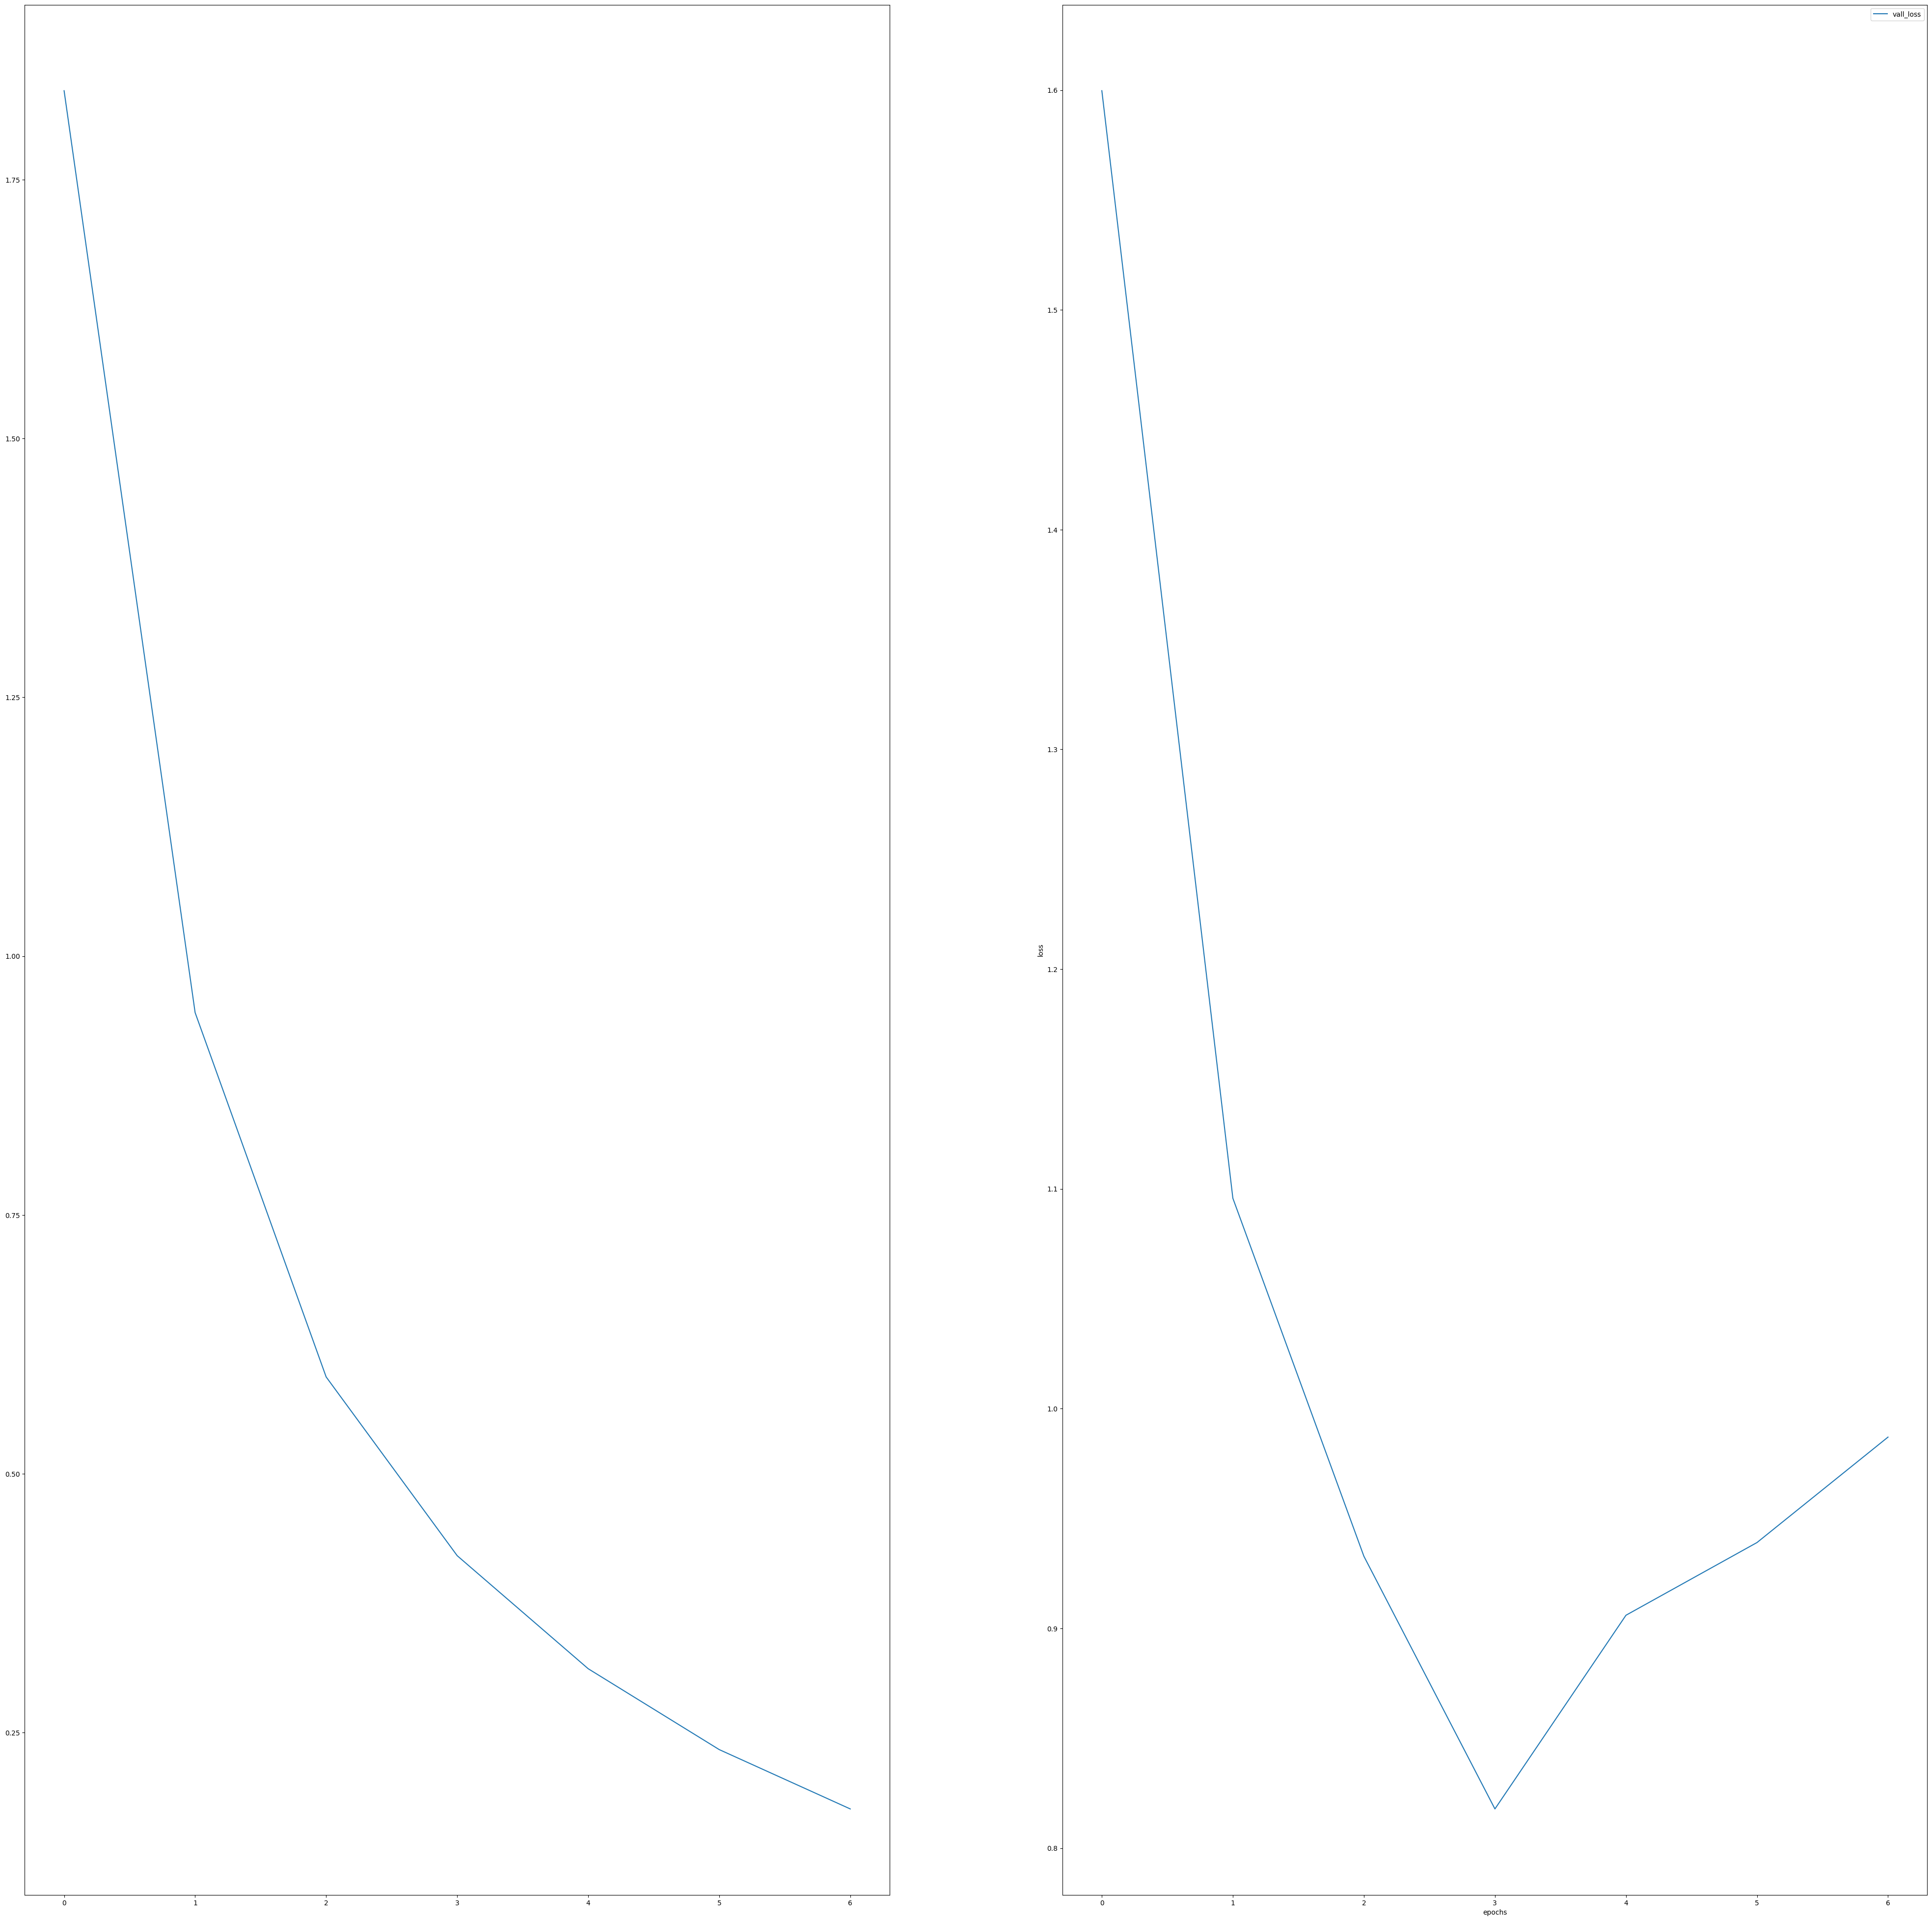

F1-оценка: 0.5


In [74]:
test_neural_3(test_dataset)

In [86]:
def test_neural_4():
    epoch = 6
    aug_count = 400
    result_array = []
    model_4 = SimpleCnn(n_classes).to(DEVICE)
    new_val = MyDataset(files=val_files, mode='val')
    new_train = MyDataset(files=train_files, mode='train', augmentation_count=aug_count)

    history_4 = train(new_train, new_val, model=model_4, epochs=epoch, batch_size=16)
    calc_score(model_4, val_dataset)
    loss, acc, val_loss, val_acc = zip(*history_4)
    result_array.append((loss, val_loss))

    figure, ax = plt.subplots(1, 2, figsize=(50, 50))
    for loss, val_loss in result_array:
        ax[0].plot(loss, label="train_loss")
        ax[1].plot(val_loss, label="vall_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    return result_array
    

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.8590585324056392


epoch:  17%|█▋        | 1/6 [02:09<10:49, 129.95s/it]


Epoch 001 train_loss: 1.8591     val_loss 1.6382 train_acc 0.3665 val_acc 0.5697
loss 0.9063099404111532


epoch:  33%|███▎      | 2/6 [04:17<08:34, 128.75s/it]


Epoch 002 train_loss: 0.9063     val_loss 1.0466 train_acc 0.6593 val_acc 0.7174
loss 0.5600892142836733


epoch:  50%|█████     | 3/6 [06:24<06:23, 127.98s/it]


Epoch 003 train_loss: 0.5601     val_loss 0.8734 train_acc 0.7716 val_acc 0.7703
loss 0.38983890081172545


epoch:  67%|██████▋   | 4/6 [08:30<04:13, 126.86s/it]


Epoch 004 train_loss: 0.3898     val_loss 0.9739 train_acc 0.8336 val_acc 0.7459
loss 0.2765875633176447


epoch:  83%|████████▎ | 5/6 [10:35<02:06, 126.45s/it]


Epoch 005 train_loss: 0.2766     val_loss 0.8195 train_acc 0.8762 val_acc 0.7982
loss 0.2140259622335907


epoch: 100%|██████████| 6/6 [12:43<00:00, 127.18s/it]



Epoch 006 train_loss: 0.2140     val_loss 0.9661 train_acc 0.9011 val_acc 0.7906
F1-оценка: 0.7


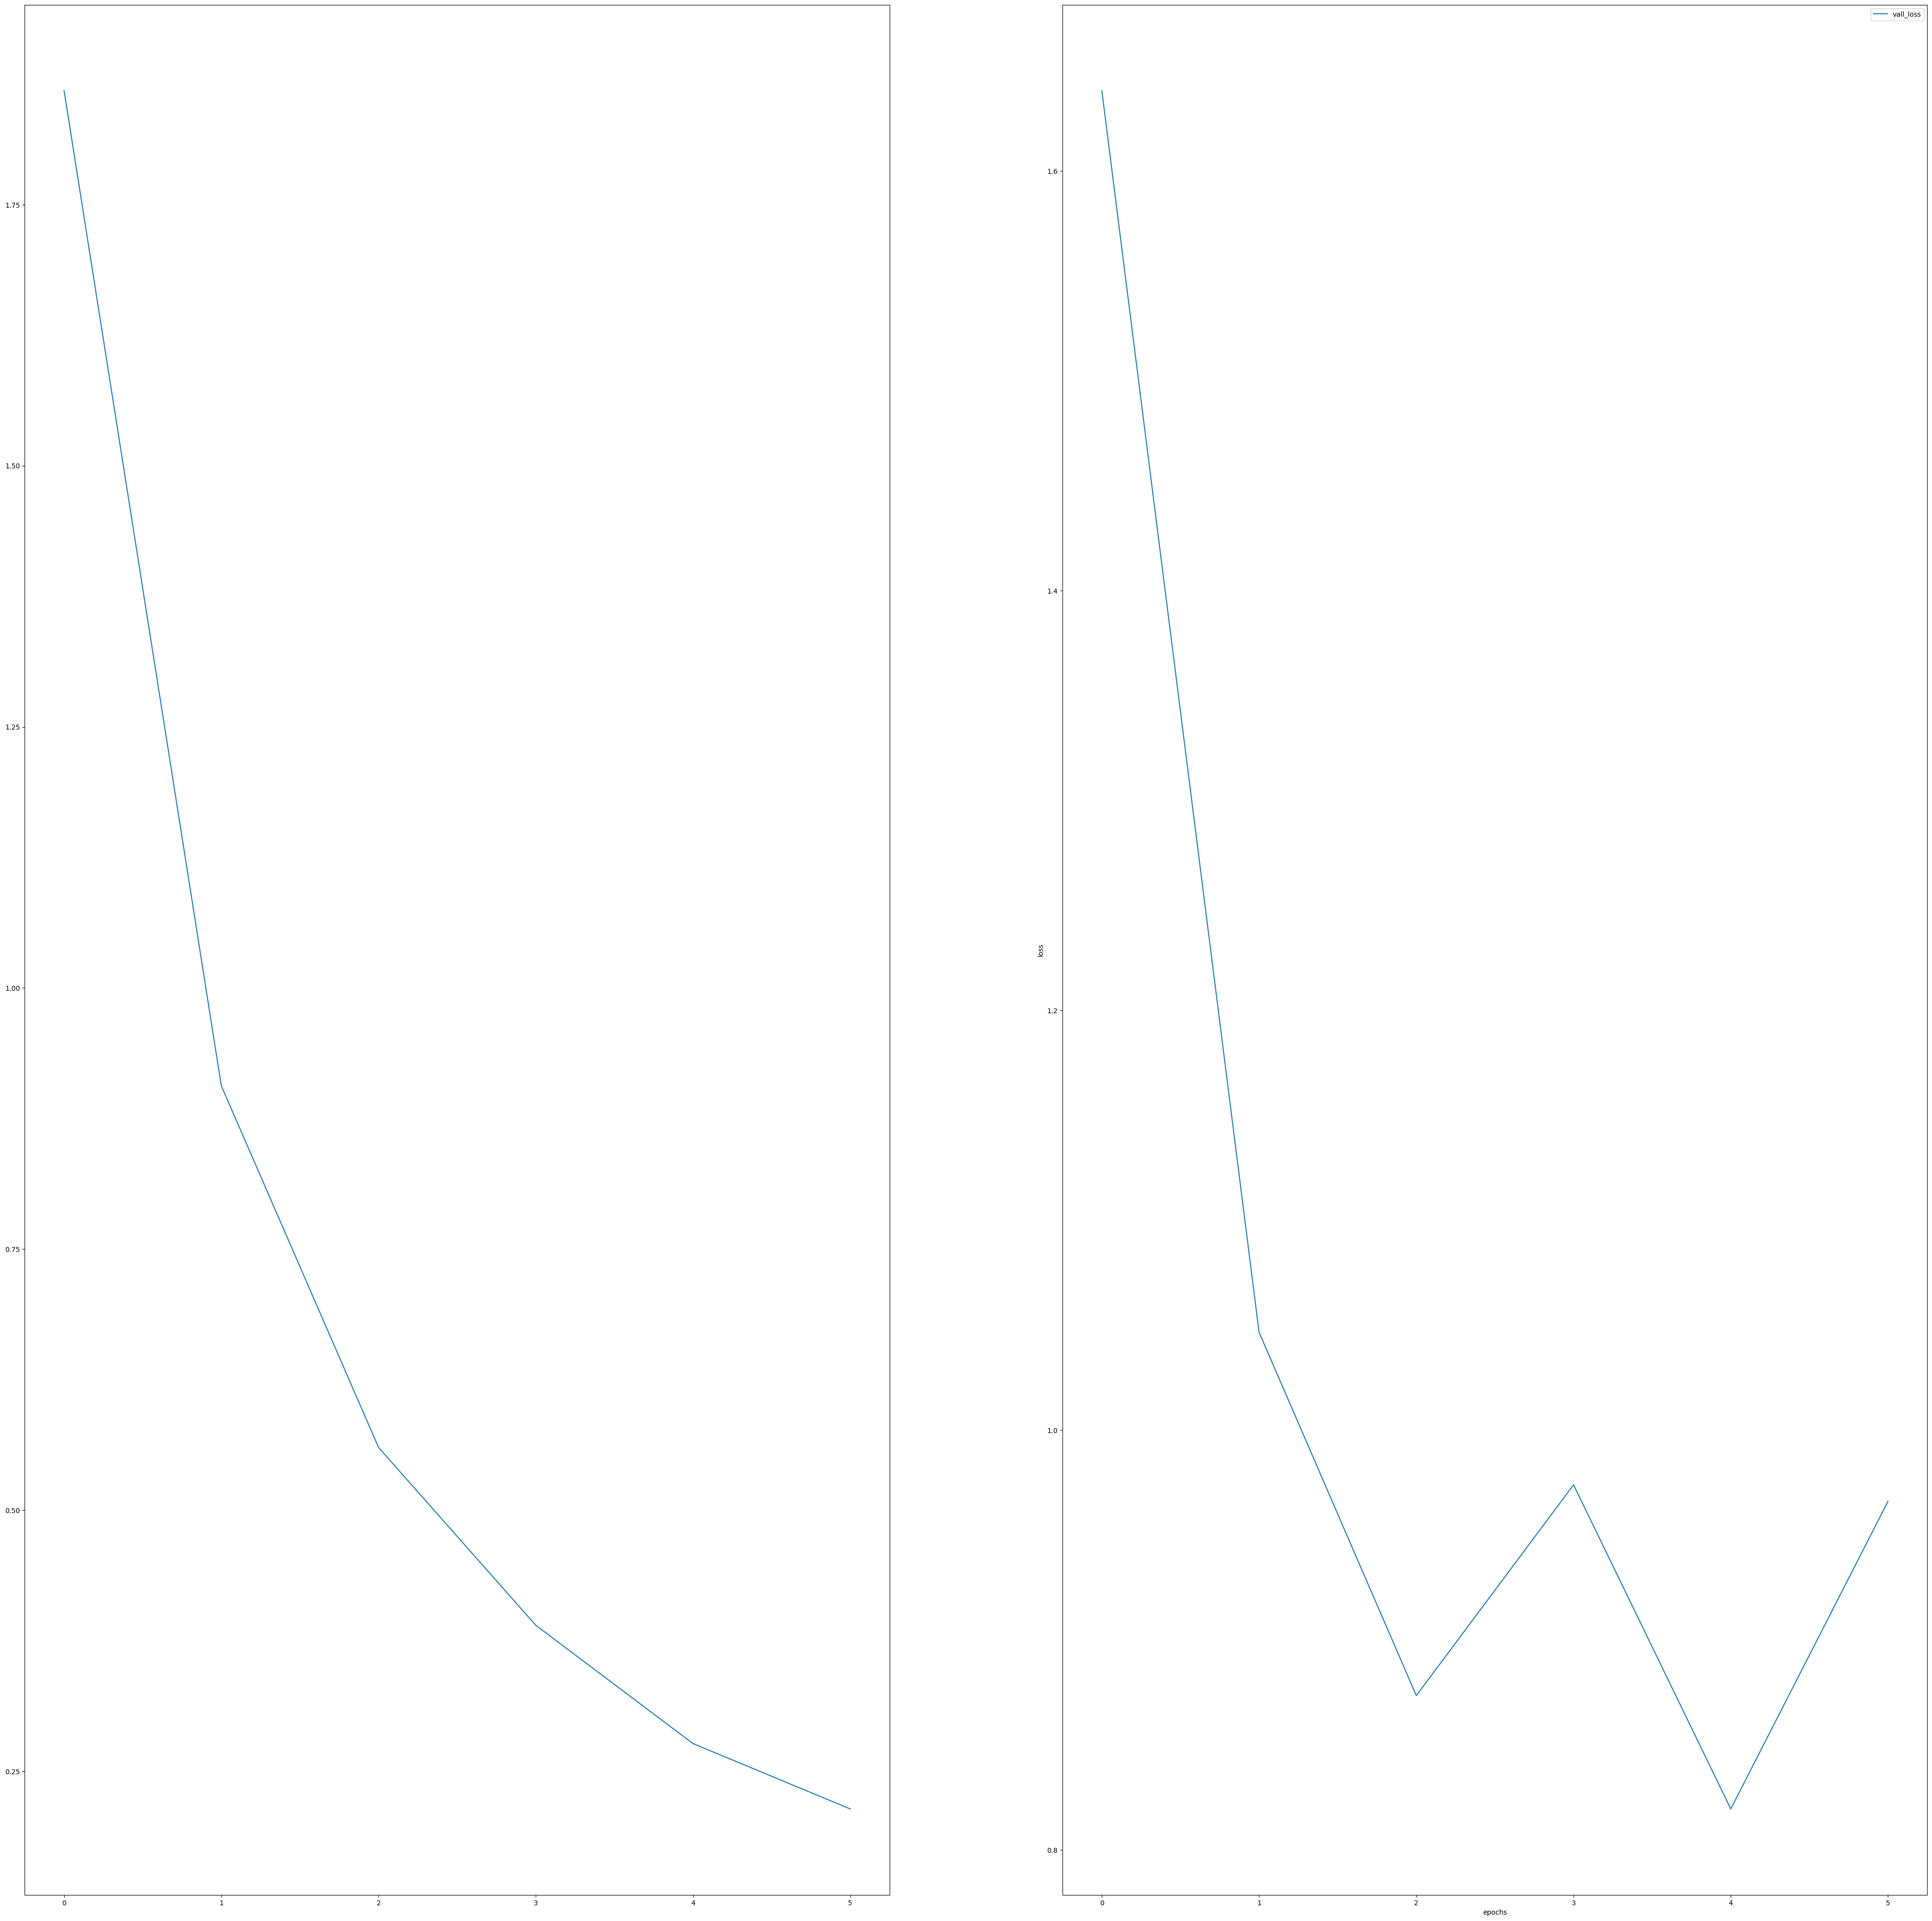

In [87]:
result_arr_4 = test_neural_4()

In [91]:
def test_neural_5():
    epochs = [5, 7, 9, 11, 13]
    batch_size_array = [128, 64, 32, 16, 8, 4]
    result_dict = dict()
    for batch_size in batch_size_array:
        result_dict[batch_size] = []
        for epoch in epochs:
            model_5 = SimpleCnn(n_classes).to(DEVICE)
            history_5 = train(train_dataset, val_dataset, model=model_5, epochs=epoch, batch_size=batch_size)
            calc_score(model_5, val_dataset)
            loss, acc, val_loss, val_acc = zip(*history_5)
            result_dict[batch_size].append((loss, val_loss, epoch))
    return result_dict

    # figure, ax = plt.subplots(1, 2, figsize=(50, 50))
    # for loss, val_loss in result_array:
    #     ax[0].plot(loss, label="train_loss")
    #     ax[1].plot(val_loss, label="vall_loss")
    # plt.legend(loc='best')
    # plt.xlabel("epochs")
    # plt.ylabel("loss")
    # plt.show()

In [ ]:
result_history_5 = test_neural_5()

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.5746315108931697


epoch:  20%|██        | 1/5 [02:25<09:40, 145.05s/it]


Epoch 001 train_loss: 2.5746     val_loss 2.3565 train_acc 0.1383 val_acc 0.2688
loss 1.7410062603589356


epoch:  40%|████      | 2/5 [04:30<06:40, 133.60s/it]


Epoch 002 train_loss: 1.7410     val_loss 1.7329 train_acc 0.4058 val_acc 0.4696
loss 1.2606565624796302


epoch:  60%|██████    | 3/5 [06:38<04:21, 130.79s/it]


Epoch 003 train_loss: 1.2607     val_loss 1.1888 train_acc 0.5544 val_acc 0.6144
loss 0.9406316427373834


epoch:  80%|████████  | 4/5 [08:44<02:08, 128.94s/it]


Epoch 004 train_loss: 0.9406     val_loss 0.9618 train_acc 0.6507 val_acc 0.6800
loss 0.7390035110238601


epoch: 100%|██████████| 5/5 [10:51<00:00, 130.25s/it]



Epoch 005 train_loss: 0.7390     val_loss 0.8300 train_acc 0.7149 val_acc 0.7262
F1-оценка: 0.55


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.3629751949296938


epoch:  14%|█▍        | 1/7 [02:05<12:32, 125.35s/it]


Epoch 001 train_loss: 2.3630     val_loss 1.9949 train_acc 0.2059 val_acc 0.3754
loss 1.5492193960932397


epoch:  29%|██▊       | 2/7 [04:11<10:27, 125.57s/it]


Epoch 002 train_loss: 1.5492     val_loss 1.4660 train_acc 0.4630 val_acc 0.5355
loss 1.141462627421732


epoch:  43%|████▎     | 3/7 [06:16<08:22, 125.66s/it]


Epoch 003 train_loss: 1.1415     val_loss 1.1490 train_acc 0.5899 val_acc 0.6246
loss 0.8542710446052411


epoch:  57%|█████▋    | 4/7 [08:21<06:16, 125.42s/it]


Epoch 004 train_loss: 0.8543     val_loss 0.9869 train_acc 0.6803 val_acc 0.6721
loss 0.6488238727239994


epoch:  71%|███████▏  | 5/7 [10:27<04:11, 125.53s/it]


Epoch 005 train_loss: 0.6488     val_loss 0.8594 train_acc 0.7511 val_acc 0.7142
loss 0.5068700696125221


epoch:  86%|████████▌ | 6/7 [12:34<02:06, 126.04s/it]


Epoch 006 train_loss: 0.5069     val_loss 0.7956 train_acc 0.7994 val_acc 0.7497
loss 0.397288261175429


epoch: 100%|██████████| 7/7 [14:40<00:00, 125.78s/it]



Epoch 007 train_loss: 0.3973     val_loss 0.7579 train_acc 0.8407 val_acc 0.7730
F1-оценка: 0.7


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 2.3551563489390785


epoch:  11%|█         | 1/9 [02:07<17:01, 127.67s/it]


Epoch 001 train_loss: 2.3552     val_loss 2.0148 train_acc 0.2115 val_acc 0.3722
loss 1.570790063583879


epoch:  22%|██▏       | 2/9 [04:13<14:46, 126.65s/it]


Epoch 002 train_loss: 1.5708     val_loss 1.3806 train_acc 0.4575 val_acc 0.5533
loss 1.082585513781602


epoch:  33%|███▎      | 3/9 [06:19<12:36, 126.15s/it]


Epoch 003 train_loss: 1.0826     val_loss 1.0350 train_acc 0.6111 val_acc 0.6590
loss 0.7762452685359906


epoch:  44%|████▍     | 4/9 [08:25<10:31, 126.32s/it]


Epoch 004 train_loss: 0.7762     val_loss 0.8640 train_acc 0.7102 val_acc 0.7086
loss 0.5930493692735462


epoch:  56%|█████▌    | 5/9 [10:30<08:23, 125.91s/it]


Epoch 005 train_loss: 0.5930     val_loss 0.7927 train_acc 0.7694 val_acc 0.7388
loss 0.459657581894783


epoch:  67%|██████▋   | 6/9 [12:36<06:16, 125.64s/it]


Epoch 006 train_loss: 0.4597     val_loss 0.8239 train_acc 0.8197 val_acc 0.7438
loss 0.35032687443321286


epoch:  78%|███████▊  | 7/9 [14:42<04:11, 125.88s/it]


Epoch 007 train_loss: 0.3503     val_loss 0.7008 train_acc 0.8603 val_acc 0.7726
loss 0.26999622566683734


epoch:  89%|████████▉ | 8/9 [16:49<02:06, 126.40s/it]


Epoch 008 train_loss: 0.2700     val_loss 0.7099 train_acc 0.8911 val_acc 0.7837
loss 0.1986020604532094


epoch: 100%|██████████| 9/9 [18:56<00:00, 126.32s/it]



Epoch 009 train_loss: 0.1986     val_loss 0.7950 train_acc 0.9164 val_acc 0.7874
F1-оценка: 0.5


epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 2.435971243023546


epoch:   9%|▉         | 1/11 [02:05<20:57, 125.71s/it]


Epoch 001 train_loss: 2.4360     val_loss 2.1895 train_acc 0.1829 val_acc 0.3365
loss 1.666205452311471


epoch:  18%|█▊        | 2/11 [04:15<19:12, 128.05s/it]


Epoch 002 train_loss: 1.6662     val_loss 1.5856 train_acc 0.4218 val_acc 0.4941
loss 1.2131196409739144


epoch:  27%|██▋       | 3/11 [06:22<16:59, 127.41s/it]


Epoch 003 train_loss: 1.2131     val_loss 1.1529 train_acc 0.5669 val_acc 0.6263
loss 0.8810263205405306


epoch:  36%|███▋      | 4/11 [08:28<14:49, 127.02s/it]


Epoch 004 train_loss: 0.8810     val_loss 0.9250 train_acc 0.6693 val_acc 0.6834
loss 0.6617483146608738


epoch:  45%|████▌     | 5/11 [10:36<12:43, 127.22s/it]


Epoch 005 train_loss: 0.6617     val_loss 0.8461 train_acc 0.7439 val_acc 0.7125
loss 0.5220753646320625


epoch:  55%|█████▍    | 6/11 [12:45<10:39, 127.82s/it]


Epoch 006 train_loss: 0.5221     val_loss 0.7787 train_acc 0.7910 val_acc 0.7381
loss 0.4089591433131867


epoch:  64%|██████▎   | 7/11 [14:52<08:31, 127.85s/it]


Epoch 007 train_loss: 0.4090     val_loss 0.7746 train_acc 0.8348 val_acc 0.7514
loss 0.31102628395112275


epoch:  73%|███████▎  | 8/11 [17:01<06:24, 128.17s/it]


Epoch 008 train_loss: 0.3110     val_loss 0.8000 train_acc 0.8709 val_acc 0.7516
loss 0.2441032490378558


epoch:  82%|████████▏ | 9/11 [19:09<04:16, 128.04s/it]


Epoch 009 train_loss: 0.2441     val_loss 0.7440 train_acc 0.8992 val_acc 0.7747
loss 0.19180537656939586


epoch:  91%|█████████ | 10/11 [21:15<02:07, 127.51s/it]


Epoch 010 train_loss: 0.1918     val_loss 0.8345 train_acc 0.9185 val_acc 0.7807
loss 0.1430545341031507


epoch: 100%|██████████| 11/11 [23:22<00:00, 127.54s/it]



Epoch 011 train_loss: 0.1431     val_loss 0.9486 train_acc 0.9361 val_acc 0.7726
F1-оценка: 0.9


epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 2.3720727031098345


epoch:   8%|▊         | 1/13 [02:07<25:25, 127.16s/it]


Epoch 001 train_loss: 2.3721     val_loss 2.0125 train_acc 0.2008 val_acc 0.3756
loss 1.529735181049007


epoch:  15%|█▌        | 2/13 [04:12<23:07, 126.10s/it]


Epoch 002 train_loss: 1.5297     val_loss 1.3668 train_acc 0.4629 val_acc 0.5472
loss 1.1019136902404991


epoch:  23%|██▎       | 3/13 [06:19<21:02, 126.29s/it]


Epoch 003 train_loss: 1.1019     val_loss 1.0999 train_acc 0.5975 val_acc 0.6284
loss 0.8156838330412163


epoch:  31%|███       | 4/13 [08:24<18:54, 126.07s/it]


Epoch 004 train_loss: 0.8157     val_loss 0.8822 train_acc 0.6888 val_acc 0.7039
loss 0.6371793304478958


epoch:  38%|███▊      | 5/13 [10:30<16:47, 125.90s/it]


Epoch 005 train_loss: 0.6372     val_loss 0.7447 train_acc 0.7474 val_acc 0.7423
loss 0.4900760269976018


epoch:  46%|████▌     | 6/13 [12:37<14:43, 126.27s/it]


Epoch 006 train_loss: 0.4901     val_loss 0.7337 train_acc 0.8030 val_acc 0.7518
loss 0.3824209143716185


epoch:  54%|█████▍    | 7/13 [14:46<12:42, 127.08s/it]


Epoch 007 train_loss: 0.3824     val_loss 0.7315 train_acc 0.8464 val_acc 0.7627
loss 0.31592314370810376


epoch:  62%|██████▏   | 8/13 [16:54<10:36, 127.35s/it]


Epoch 008 train_loss: 0.3159     val_loss 0.7089 train_acc 0.8704 val_acc 0.7786
loss 0.22660197478865762


epoch:  69%|██████▉   | 9/13 [19:01<08:29, 127.37s/it]


Epoch 009 train_loss: 0.2266     val_loss 0.7374 train_acc 0.9020 val_acc 0.7916
loss 0.18174057929741666


epoch:  77%|███████▋  | 10/13 [21:06<06:20, 126.77s/it]


Epoch 010 train_loss: 0.1817     val_loss 0.7629 train_acc 0.9229 val_acc 0.7938
loss 0.15243479828370118


epoch:  77%|███████▋  | 10/13 [23:12<06:57, 139.30s/it]


Early stopping at epoch 11
F1-оценка: 0.85


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.210823119943389


epoch:  20%|██        | 1/5 [02:02<08:08, 122.11s/it]


Epoch 001 train_loss: 2.2108     val_loss 1.9921 train_acc 0.2504 val_acc 0.4136
loss 1.342967191808003


epoch:  40%|████      | 2/5 [04:04<06:07, 122.43s/it]


Epoch 002 train_loss: 1.3430     val_loss 1.3379 train_acc 0.5270 val_acc 0.5869
loss 0.8576110515619388


epoch:  60%|██████    | 3/5 [06:08<04:05, 122.94s/it]


Epoch 003 train_loss: 0.8576     val_loss 0.9581 train_acc 0.6730 val_acc 0.7029
loss 0.6189301698674775


epoch:  80%|████████  | 4/5 [08:10<02:02, 122.77s/it]


Epoch 004 train_loss: 0.6189     val_loss 0.8595 train_acc 0.7523 val_acc 0.7358
loss 0.4452540147144313


epoch: 100%|██████████| 5/5 [10:13<00:00, 122.73s/it]



Epoch 005 train_loss: 0.4453     val_loss 0.7748 train_acc 0.8170 val_acc 0.7623
F1-оценка: 0.8000000000000002


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.185508965625832


epoch:  14%|█▍        | 1/7 [02:01<12:08, 121.42s/it]


Epoch 001 train_loss: 2.1855     val_loss 1.8691 train_acc 0.2625 val_acc 0.4530
loss 1.2030164626906865


epoch:  29%|██▊       | 2/7 [04:04<10:12, 122.57s/it]


Epoch 002 train_loss: 1.2030     val_loss 1.1706 train_acc 0.5681 val_acc 0.6418
loss 0.7814191393096231


epoch:  43%|████▎     | 3/7 [06:07<08:10, 122.58s/it]


Epoch 003 train_loss: 0.7814     val_loss 0.9261 train_acc 0.6980 val_acc 0.7170
loss 0.5644119363566463


epoch:  57%|█████▋    | 4/7 [08:08<06:05, 121.95s/it]


Epoch 004 train_loss: 0.5644     val_loss 0.8229 train_acc 0.7755 val_acc 0.7501
loss 0.4207066893867075


epoch:  71%|███████▏  | 5/7 [10:09<04:03, 121.60s/it]


Epoch 005 train_loss: 0.4207     val_loss 0.8086 train_acc 0.8272 val_acc 0.7610
loss 0.30018955866267966


epoch:  86%|████████▌ | 6/7 [12:10<02:01, 121.44s/it]


Epoch 006 train_loss: 0.3002     val_loss 0.8112 train_acc 0.8743 val_acc 0.7770
loss 0.24089360666909834


epoch: 100%|██████████| 7/7 [14:11<00:00, 121.68s/it]



Epoch 007 train_loss: 0.2409     val_loss 0.8701 train_acc 0.8962 val_acc 0.7768
F1-оценка: 0.65


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 2.2520540742572233


epoch:  11%|█         | 1/9 [02:01<16:14, 121.84s/it]


Epoch 001 train_loss: 2.2521     val_loss 1.9452 train_acc 0.2406 val_acc 0.4173
loss 1.3593620202352883


epoch:  22%|██▏       | 2/9 [04:04<14:14, 122.03s/it]


Epoch 002 train_loss: 1.3594     val_loss 1.3013 train_acc 0.5184 val_acc 0.6037
loss 0.8980482540371175


epoch:  33%|███▎      | 3/9 [06:06<12:14, 122.41s/it]


Epoch 003 train_loss: 0.8980     val_loss 1.0192 train_acc 0.6583 val_acc 0.6804
loss 0.6345688894953923


epoch:  44%|████▍     | 4/9 [08:09<10:13, 122.60s/it]


Epoch 004 train_loss: 0.6346     val_loss 0.9731 train_acc 0.7448 val_acc 0.7069
loss 0.4685842278905565


epoch:  56%|█████▌    | 5/9 [10:11<08:09, 122.39s/it]


Epoch 005 train_loss: 0.4686     val_loss 0.8274 train_acc 0.8105 val_acc 0.7528
loss 0.3547130317707048


epoch:  67%|██████▋   | 6/9 [12:12<06:05, 121.68s/it]


Epoch 006 train_loss: 0.3547     val_loss 0.7401 train_acc 0.8480 val_acc 0.7854
loss 0.27208512914876315


epoch:  78%|███████▊  | 7/9 [14:13<04:03, 121.58s/it]


Epoch 007 train_loss: 0.2721     val_loss 0.8169 train_acc 0.8861 val_acc 0.7860
loss 0.21438470437170723


epoch:  89%|████████▉ | 8/9 [16:15<02:01, 121.57s/it]


Epoch 008 train_loss: 0.2144     val_loss 0.8786 train_acc 0.9063 val_acc 0.7818
loss 0.17058598989703502


epoch:  89%|████████▉ | 8/9 [18:15<02:16, 136.94s/it]


Early stopping at epoch 9
F1-оценка: 0.85


epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 2.1846406729527055


epoch:   9%|▉         | 1/11 [02:01<20:13, 121.38s/it]


Epoch 001 train_loss: 2.1846     val_loss 1.9159 train_acc 0.2585 val_acc 0.4419
loss 1.3304790099249257


epoch:  18%|█▊        | 2/11 [04:02<18:09, 121.08s/it]


Epoch 002 train_loss: 1.3305     val_loss 1.2715 train_acc 0.5323 val_acc 0.6120
loss 0.8878866423086813


epoch:  27%|██▋       | 3/11 [06:02<16:05, 120.66s/it]


Epoch 003 train_loss: 0.8879     val_loss 0.9320 train_acc 0.6675 val_acc 0.7067
loss 0.6468677348646816


epoch:  36%|███▋      | 4/11 [08:03<14:06, 120.91s/it]


Epoch 004 train_loss: 0.6469     val_loss 0.8283 train_acc 0.7495 val_acc 0.7440
loss 0.48660321883832097


epoch:  45%|████▌     | 5/11 [10:04<12:05, 120.87s/it]


Epoch 005 train_loss: 0.4866     val_loss 0.7951 train_acc 0.8061 val_acc 0.7602
loss 0.37240372359927304


epoch:  55%|█████▍    | 6/11 [12:04<10:03, 120.74s/it]


Epoch 006 train_loss: 0.3724     val_loss 0.7558 train_acc 0.8472 val_acc 0.7858
loss 0.28709633493014936


epoch:  64%|██████▎   | 7/11 [14:05<08:02, 120.68s/it]


Epoch 007 train_loss: 0.2871     val_loss 0.8727 train_acc 0.8809 val_acc 0.7746
loss 0.21550872470324295


epoch:  73%|███████▎  | 8/11 [16:06<06:02, 120.77s/it]


Epoch 008 train_loss: 0.2155     val_loss 0.7828 train_acc 0.9078 val_acc 0.7977
loss 0.1803944939955679


epoch:  73%|███████▎  | 8/11 [18:07<06:47, 135.94s/it]


Early stopping at epoch 9
F1-оценка: 0.85


epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 2.115971647939057


epoch:   8%|▊         | 1/13 [02:01<24:23, 121.92s/it]


Epoch 001 train_loss: 2.1160     val_loss 1.7734 train_acc 0.2841 val_acc 0.4851
loss 1.253265635710141


epoch:  15%|█▌        | 2/13 [04:03<22:21, 121.95s/it]


Epoch 002 train_loss: 1.2533     val_loss 1.1658 train_acc 0.5590 val_acc 0.6441
loss 0.8640880637453182


epoch:  23%|██▎       | 3/13 [06:05<20:18, 121.82s/it]


Epoch 003 train_loss: 0.8641     val_loss 0.9754 train_acc 0.6781 val_acc 0.7069
loss 0.6232564856963702


epoch:  31%|███       | 4/13 [08:06<18:13, 121.46s/it]


Epoch 004 train_loss: 0.6233     val_loss 0.8267 train_acc 0.7567 val_acc 0.7390
loss 0.48485756634192767


epoch:  38%|███▊      | 5/13 [10:07<16:09, 121.23s/it]


Epoch 005 train_loss: 0.4849     val_loss 0.7657 train_acc 0.8061 val_acc 0.7585
loss 0.3816495654013318


epoch:  46%|████▌     | 6/13 [12:08<14:09, 121.39s/it]


Epoch 006 train_loss: 0.3816     val_loss 0.7816 train_acc 0.8446 val_acc 0.7730
loss 0.28844801476862986


epoch:  54%|█████▍    | 7/13 [14:11<12:09, 121.60s/it]


Epoch 007 train_loss: 0.2884     val_loss 0.8503 train_acc 0.8778 val_acc 0.7778
loss 0.2166359277411368


epoch:  54%|█████▍    | 7/13 [16:13<13:54, 139.11s/it]


Early stopping at epoch 8
F1-оценка: 0.6


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.9832988866036603


epoch:  20%|██        | 1/5 [02:05<08:23, 125.86s/it]


Epoch 001 train_loss: 1.9833     val_loss 1.6796 train_acc 0.3254 val_acc 0.5096
loss 1.1036221619145614


epoch:  40%|████      | 2/5 [04:09<06:13, 124.42s/it]


Epoch 002 train_loss: 1.1036     val_loss 1.0922 train_acc 0.6025 val_acc 0.6767
loss 0.7104652698453546


epoch:  60%|██████    | 3/5 [06:11<04:06, 123.37s/it]


Epoch 003 train_loss: 0.7105     val_loss 0.9122 train_acc 0.7223 val_acc 0.7300
loss 0.5062856418646873


epoch:  80%|████████  | 4/5 [08:13<02:02, 122.90s/it]


Epoch 004 train_loss: 0.5063     val_loss 0.8083 train_acc 0.7950 val_acc 0.7598
loss 0.35866235762206194


epoch: 100%|██████████| 5/5 [10:17<00:00, 123.42s/it]



Epoch 005 train_loss: 0.3587     val_loss 0.7780 train_acc 0.8485 val_acc 0.7833
F1-оценка: 0.9500000000000001


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 1.9469844916837444


epoch:  14%|█▍        | 1/7 [02:03<12:23, 123.85s/it]


Epoch 001 train_loss: 1.9470     val_loss 1.5294 train_acc 0.3351 val_acc 0.5510
loss 1.012664219840893


epoch:  29%|██▊       | 2/7 [04:06<10:15, 123.13s/it]


Epoch 002 train_loss: 1.0127     val_loss 1.1570 train_acc 0.6277 val_acc 0.6486
loss 0.6346568916833236


epoch:  43%|████▎     | 3/7 [06:11<08:15, 123.98s/it]


Epoch 003 train_loss: 0.6347     val_loss 0.8569 train_acc 0.7499 val_acc 0.7411
loss 0.4318022773868605


epoch:  57%|█████▋    | 4/7 [08:14<06:10, 123.53s/it]


Epoch 004 train_loss: 0.4318     val_loss 0.7857 train_acc 0.8215 val_acc 0.7837
loss 0.30619660219392


epoch:  71%|███████▏  | 5/7 [10:15<04:05, 122.77s/it]


Epoch 005 train_loss: 0.3062     val_loss 0.7639 train_acc 0.8699 val_acc 0.7958
loss 0.22658583739869373


epoch:  86%|████████▌ | 6/7 [12:19<02:03, 123.08s/it]


Epoch 006 train_loss: 0.2266     val_loss 0.7845 train_acc 0.9012 val_acc 0.7954
loss 0.16398461760836913


epoch: 100%|██████████| 7/7 [14:22<00:00, 123.28s/it]



Epoch 007 train_loss: 0.1640     val_loss 0.8705 train_acc 0.9272 val_acc 0.8021
F1-оценка: 0.7


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 1.9258194679484655


epoch:  11%|█         | 1/9 [02:05<16:40, 125.11s/it]


Epoch 001 train_loss: 1.9258     val_loss 1.5872 train_acc 0.3410 val_acc 0.5445
loss 1.0505387928578662


epoch:  22%|██▏       | 2/9 [04:09<14:31, 124.49s/it]


Epoch 002 train_loss: 1.0505     val_loss 1.0738 train_acc 0.6148 val_acc 0.6813
loss 0.679735560422187


epoch:  33%|███▎      | 3/9 [06:13<12:26, 124.40s/it]


Epoch 003 train_loss: 0.6797     val_loss 0.8963 train_acc 0.7325 val_acc 0.7281
loss 0.4827169845860371


epoch:  44%|████▍     | 4/9 [08:17<10:21, 124.26s/it]


Epoch 004 train_loss: 0.4827     val_loss 0.8219 train_acc 0.8014 val_acc 0.7547
loss 0.3485435604208161


epoch:  56%|█████▌    | 5/9 [10:21<08:17, 124.33s/it]


Epoch 005 train_loss: 0.3485     val_loss 0.7857 train_acc 0.8538 val_acc 0.7791
loss 0.25514706601549225


epoch:  67%|██████▋   | 6/9 [12:26<06:13, 124.52s/it]


Epoch 006 train_loss: 0.2551     val_loss 0.7973 train_acc 0.8861 val_acc 0.7923
loss 0.19156439202011327


epoch:  78%|███████▊  | 7/9 [14:31<04:08, 124.47s/it]


Epoch 007 train_loss: 0.1916     val_loss 0.9314 train_acc 0.9146 val_acc 0.7864
loss 0.15099721464670587


epoch:  78%|███████▊  | 7/9 [16:37<04:45, 142.51s/it]


Early stopping at epoch 8
F1-оценка: 0.9


epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 1.9584356524608828


epoch:   9%|▉         | 1/11 [02:08<21:28, 128.86s/it]


Epoch 001 train_loss: 1.9584     val_loss 1.6941 train_acc 0.3301 val_acc 0.5178
loss 1.0733939846523766


epoch:  18%|█▊        | 2/11 [04:16<19:10, 127.85s/it]


Epoch 002 train_loss: 1.0734     val_loss 1.0670 train_acc 0.6091 val_acc 0.6840
loss 0.690787252308996


epoch:  27%|██▋       | 3/11 [06:22<16:57, 127.18s/it]


Epoch 003 train_loss: 0.6908     val_loss 0.8785 train_acc 0.7309 val_acc 0.7312
loss 0.49927460226225046


epoch:  36%|███▋      | 4/11 [08:29<14:51, 127.34s/it]


Epoch 004 train_loss: 0.4993     val_loss 0.8414 train_acc 0.8002 val_acc 0.7566
loss 0.3633091378435222


epoch:  45%|████▌     | 5/11 [10:35<12:39, 126.57s/it]


Epoch 005 train_loss: 0.3633     val_loss 0.7828 train_acc 0.8502 val_acc 0.7778
loss 0.2690963465982626


epoch:  55%|█████▍    | 6/11 [12:39<10:29, 125.88s/it]


Epoch 006 train_loss: 0.2691     val_loss 0.8921 train_acc 0.8832 val_acc 0.7702
loss 0.21369383205873313


epoch:  64%|██████▎   | 7/11 [14:43<08:20, 125.03s/it]


Epoch 007 train_loss: 0.2137     val_loss 0.8715 train_acc 0.9080 val_acc 0.7812


In [ ]:
def test_neural_6():
    aug_count = 400
    new_val = MyDataset(files=val_files, mode='val')
    new_train = MyDataset(files=train_files, mode='train', augmentation_count=aug_count)
    
    epochs = [5, 7, 9, 11, 13]
    batch_size_array = [128, 64, 32, 16, 8, 4]
    result_dict = dict()
    for batch_size in batch_size_array:
        result_dict[batch_size] = []
        for epoch in epochs:
            model_6 = SimpleCnn(n_classes).to(DEVICE)
            history_6 = train(new_train, new_val, model=model_6, epochs=epoch, batch_size=batch_size)
            calc_score(model_6, new_val)
            loss, acc, val_loss, val_acc = zip(*history_6)
            result_dict[batch_size].append((loss, val_loss, epoch))
    return result_dict

In [ ]:
result_history_6 = test_neural_6()

In [ ]:
class MySimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.out = nn.Sequential(
            n.Linear(96 * 5 * 5, n_classes)
            # nn.BatchNorm1d(96 * 5 * 5),
            # nn.Dropout(),
            # nn.ReLU(),
        )
        # self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        # x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def test_neural_7():
    epoch = 8
    aug_count = 400
    result_array = []
    model_5 = MySimpleCnn(n_classes).to(DEVICE)
    new_val = MyDataset(files=val_files, mode='val')
    new_train = MyDataset(files=train_files, mode='train', augmentation_count=aug_count)

    history_4 = train(new_train, new_val, model=model_5, epochs=epoch, batch_size=64)
    calc_score(model_4, val_dataset)
    loss, acc, val_loss, val_acc = zip(*history_3)
    result_array.append((loss, val_loss))
    return result_array